# SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

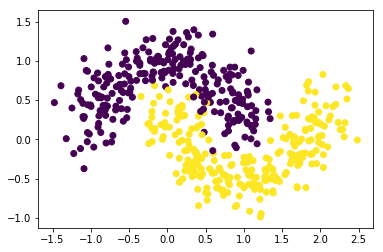

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

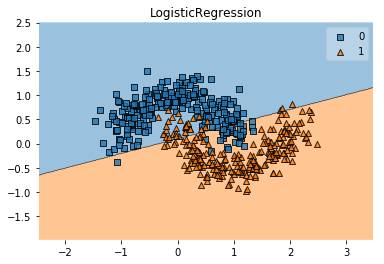

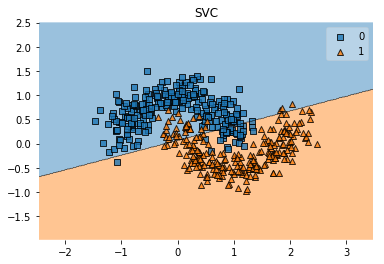

LogisticRegression accuracy score: 0.856
SVM accuracy score: 0.862
LogisticRegression F1 score: 0.855
SVM F1 score: 0.861
LogisticRegression R^2 coefficient: 0.856
SVM R^2 coefficient: 0.862


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

lr = LogisticRegression(C=1, solver='lbfgs') # add some params
svm = SVC(C=10, kernel='linear') # here too
### YOUR CODE HERE

# This class is made for faster accsess to routine things.
class plot_and_measure:
    def __init__(self, X, y, estimator, average='binary'):
        self.X = X
        self.y = y
        self.estimator = estimator
        self.average = average
        
    def fit(self):
        self.estimator.fit(self.X, self.y)
        
    def plot_decisions(self):
        plot_decision_regions(self.X, self.y, clf=self.estimator)
        plt.title(self.estimator.__class__.__name__)
        plt.show()
    
    def measure_acc(self):
        return accuracy_score(self.y, self.estimator.predict(self.X))

    def measure_R2(self):
        return self.estimator.score(self.X, self.y)
    
    def measure_f1(self):
        return f1_score(self.y, self.estimator.predict(self.X), average=self.average)


lr_class = plot_and_measure(moons_points, moons_labels, lr)
lr_class.fit()
svm_class = plot_and_measure(moons_points, moons_labels, svm)
svm_class.fit()


lr_class.plot_decisions()
svm_class.plot_decisions()

print("LogisticRegression accuracy score:", round(lr_class.measure_acc(), 3))
print("SVM accuracy score:", round(svm_class.measure_acc(), 3))

print("LogisticRegression F1 score:", round(lr_class.measure_f1(), 3))
print("SVM F1 score:", round(svm_class.measure_f1(), 3))

print("LogisticRegression R^2 coefficient:", round(lr_class.measure_R2(), 3))
print("SVM R^2 coefficient:", round(svm_class.measure_R2(), 7))

As it can be seen, results obtained are not as good as they can be. Linear kernel for SVM and logistic regression do not find regularity in the data given, but try only to be adjusted to the maximum quality of the prediction.

## 1.2 Kernel tirck

![keep-calm](imgs/keep-calm.jpg)

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

Kernel: poly
Best params: {'classifier__C': 9, 'classifier__degree': 7}


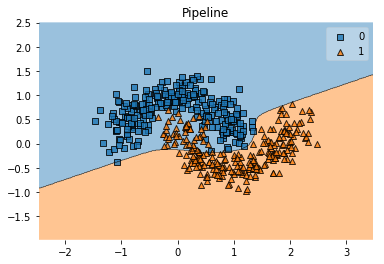

F1 score: 0.871331828442438
Kernel: rbf
Best params: {'classifier__C': 10}


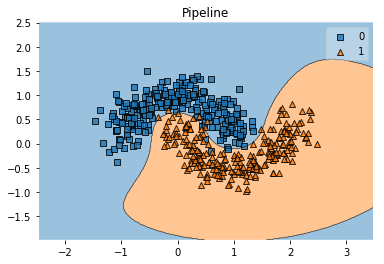

F1 score: 0.9799196787148594
Kernel: sigmoid
Best params: {'classifier__C': 7}


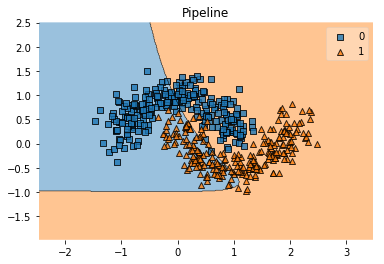

F1 score: 0.5485714285714286


In [4]:
### YOUR CODE HERE

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer

# Class for this very task.
class kernel_trick(plot_and_measure):
    
    # This very class is inherited from the previous one.
    def __init__(self, X, y, estimator, kernel=None, degree_GSCV=None, average='binary'):
        super().__init__(X, y, estimator, average=average)
        
        # Define kernel used for beautiful output.
        self.kernel = kernel
        self.degree_GSCV = degree_GSCV
        if kernel == 'poly':
            
            # If it is not predefined.
            if self.degree_GSCV is None:
                self.degree_GSCV = np.arange(2, 10)
        self.C_GSCV = np.arange(1, 15)

    def find_best_C(self):
        pipe_min_max_scaler = Pipeline([('scaler', MinMaxScaler()),
                                        ('classifier', self.estimator)])
        pipe_stand_scaler = Pipeline([('scaler', StandardScaler()),
                                      ('classifier', self.estimator)])
        
        scoring = make_scorer(f1_score, average=self.average)
        
        param = dict()
        param['classifier__C'] = self.C_GSCV
        if self.kernel == 'poly':
            param['classifier__degree'] = self.degree_GSCV
            
        gsearch_min_max_scaler = GridSearchCV(estimator=pipe_min_max_scaler, param_grid=param, scoring=scoring, cv=3)
        gsearch_min_max_scaler.fit(self.X, self.y)
        
        gsearch_standart_scaler = GridSearchCV(estimator=pipe_stand_scaler, param_grid=param, scoring=scoring, cv=3)
        gsearch_standart_scaler.fit(self.X, self.y)
        
        # Return the best scaler and results of grid search for it.
        return (MinMaxScaler(), gsearch_min_max_scaler.best_params_) if gsearch_min_max_scaler.best_score_ \
            > gsearch_standart_scaler.best_score_ else \
            (StandardScaler(), gsearch_standart_scaler.best_params_)

    def result(self, print_plot=True):
        ans = self.find_best_C()
        if self.kernel == 'poly':
            pipe = Pipeline([('scaler', ans[0]),
                         ('classifier', SVC(kernel=self.kernel, gamma='scale', C=ans[1]['classifier__C'],
                                        degree=ans[1]['classifier__degree']))])
        else:
            pipe = Pipeline([('scaler', ans[0]),
                         ('classifier', SVC(kernel=self.kernel, gamma='scale', C=ans[1]['classifier__C']))])   
        print("Kernel:", self.kernel)
        print("Best params:", ans[1])
        final_model = plot_and_measure(self.X, self.y, pipe, average=self.average)
        final_model.fit()
        if print_plot:
            final_model.plot_decisions()
        print("F1 score:", final_model.measure_f1())

poly_class = kernel_trick(moons_points, moons_labels, SVC(kernel='poly'), kernel='poly')
rbf_class = kernel_trick(moons_points, moons_labels, SVC(kernel='rbf'), kernel='rbf')
sigmoid_class = kernel_trick(moons_points, moons_labels, SVC(kernel='sigmoid'), kernel='sigmoid')

poly_class.result()
rbf_class.result()
sigmoid_class.result()

* As it can be seen, classification quality has increased in the second variant due to usage of nonlinear models for the data given. As it can be understood, not all kernels are suitable for this very task. For instance, the quality with sigmoid is not appropriate because it does not find regularity in the data given.
* For all pictures it can be said that the border is not linear any more. On the first picture the border is linear far from the middle and looks like a part of a circle in the center. In the second picture the closed smooth figure is presented. For instance, it looks like a squeezed ellipse. On the third picture the border looks like a squeezed derivative of sigmoid function.
* I've made a GridSearchCV to find the best degree. As it can be seen, $degree = 7$ stands to be the best in this very case.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [5]:
from sklearn.preprocessing import PolynomialFeatures

### YOUR CODE HERE

pipe = Pipeline([('scaler', StandardScaler()),
                 ('poly_feature', PolynomialFeatures()),
                 ('classifier', LogisticRegression(solver='lbfgs', n_jobs=-1))])

param = {
    "poly_feature__degree": np.arange(0, 9),
    "classifier__C": np.arange(1, 15),
}

gsearch = GridSearchCV(estimator=pipe, param_grid=param, scoring='f1', cv=3)

gsearch.fit(moons_points, moons_labels)

print("The best LogReg params:", gsearch.best_params_, gsearch.best_score_)

print("Let's calculate SVM result with the same kernel.")

poly_class_special_degree = kernel_trick(moons_points, moons_labels, SVC(kernel='poly'), kernel='poly',  degree_GSCV=
                                        [gsearch.best_params_["poly_feature__degree"]])

poly_class_special_degree.result(print_plot=False)

The best LogReg params: {'classifier__C': 2, 'poly_feature__degree': 6} 0.9799494843485439
Let's calculate SVM result with the same kernel.
Kernel: poly
Best params: {'classifier__C': 12, 'classifier__degree': 6}
F1 score: 0.9028571428571429


* The solution found is even better than the previous solution gained with SVM method!
* As it can be seen, the SVM solution obtained with $degree = 6$, which stands to be the best variant for PolyFeature LR, is not so good:(

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

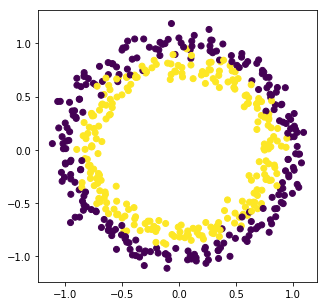

In [6]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

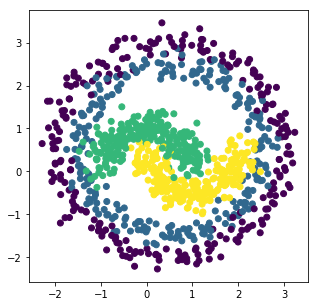

In [7]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

Kernel: rbf
Best params: {'classifier__C': 13}


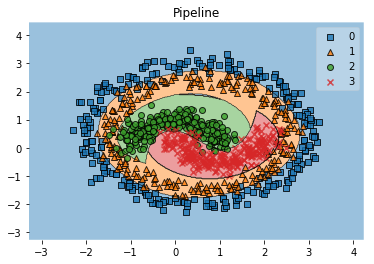

F1 score: 0.9390487435359329


In [8]:
### YOUR CODE HERE

rbf_classes_multi = kernel_trick(points, labels, SVC(kernel='rbf'), kernel='rbf', average='weighted')
rbf_classes_multi.result()

In [9]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('poly_feature', PolynomialFeatures()),
                 ('classifier', LogisticRegression(solver='lbfgs', n_jobs=-1))])

param = {
    "poly_feature__degree": np.arange(0, 9),
    "classifier__C": np.arange(1, 10)
}

scoring = make_scorer(f1_score, average='weighted')

gsearch = GridSearchCV(estimator=pipe, param_grid=param, scoring=scoring, cv=3)

gsearch.fit(points, labels)

print("The best LogReg params:", gsearch.best_params_, gsearch.best_score_)

The best LogReg params: {'classifier__C': 8, 'poly_feature__degree': 6} 0.9281233601524425


As it can be seen, SVC with rbf kernel shows the best results (because it projects ellipsis on the surface). It ought to mention that I've chosen rbf kernel judging by the pictures obtained above. It's obvious that it the best suitable model for the data presented.